# Estimating segmentation uncertainty of a convolution neural network to segment retina image

- Estimation of aleatoric and epistemic uncertainty in a DNN model for segmentation, based on the following papers (in particular, Kwon et al. 2018):
  - Kwon, Won, Kim and Paik (2018), Uncertainty quantification using Bayesian neural networks in classification  
  https://openreview.net/pdf?id=Sk_P2Q9sG
  - Gal and Ghahramani (2016) Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning  
  https://arxiv.org/pdf/1506.02142.pdf
  - Kendall and Gal (2017), What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?  
  https://arxiv.org/pdf/1703.04977.pdf


- Trains a modified UNet on the [DRIVE dataset](http://www.isi.uu.nl/Research/Databases/DRIVE/) [Staal et al, 2004] to segment retinal images:
  - J.J. Staal, M.D. Abramoff, M. Niemeijer, M.A. Viergever, B. van Ginneken, "[Ridge based vessel segmentation in color images of the retina](http://www.isi.uu.nl/Research/Databases/DRIVE/id=855.html)", IEEE Transactions on Medical Imaging, 2004, vol. 23, pp. 501-509.


## Approach

1. Train a UNet as usual, but with Dropout
2. At inference time, run model `T` times while applying Dropout and save individual predictions in array `p_hat` (`shape=(T, height, width, channels)`)
    ```
    x = Dropout(rate=0.25)(x, training=True) 
    ```
See https://github.com/keras-team/keras/issues/9412#issuecomment-366487249
3. Then, compute the mean prediction and the aleatoric and epistemic uncertainties as:
    ```
    prediction = np.mean(p_hat, axis=0)
    aleatoric  = np.mean(p_hat*(1-p_hat), axis=0)
    epistemic  = np.mean(p_hat**2, axis=0) - np.mean(p_hat, axis=0)**2
    ```

# Imports

In [3]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os, glob
import zipfile # extract zip
from skimage.external import tifffile # read tiff images
#from skimage.io import imread # read gif images
from skimage.transform import resize # resize images

# Preparing the data

__Loading the image data__

The image data will be imported as tensors of shape: NUM x WIDTH x HEIGHT.

The labels will be imported as tensors of shape: NUM x 1

In [4]:
# unzip data set
with zipfile.ZipFile("../data/DRIVE_retinal_image_data.zip","r") as zip_ref:
    zip_ref.extractall("../data")

In [5]:
# load training images
fns = sorted(glob.glob('../data/DRIVE/training/images/*.tif'))
#print(fns)
x_train = np.array([tifffile.imread(fn) for fn in fns])

# load test images
fns = sorted(glob.glob('../data/DRIVE/test/images/*.tif'))
#print(fns)
x_test = np.array([tifffile.imread(fn) for fn in fns])
print(x_train.shape)
print(x_test.shape)

/home/debacwa/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


(31, 584, 565, 3)
(9, 584, 565, 3)


In [6]:
# load training annotations
fns = sorted(glob.glob('../data/DRIVE/training/labels/*.gif'))
y_train = np.array([imread(fn) for fn in fns]) # read images
y_train = np.expand_dims(y_train, -1) # add channels dimension

# load test annotations
fns = sorted(glob.glob('../data/DRIVE/test/labels/*.gif'))
y_test = np.array([imread(fn) for fn in fns]) # read images
y_test = np.expand_dims(y_test, -1) # add channels dimension

**Preprocessing**

- Convert to float32
- Rescale to 0-1 interval

In [7]:
def preprocess(ims):
    # convert to float32
    ims = ims.astype(np.float32)

    # scale to 0-1 interval
    if ims.max() > 1.0:
        ims /= 255.
    
    print('min: {}, max: {}, shape: {}, type: {}'.format(ims.min(), ims.max(), ims.shape, ims.dtype))
    return ims

x_train = preprocess(x_train)
x_test = preprocess(x_test)

y_train = preprocess(y_train)
y_test = preprocess(y_test)


min: 0.0, max: 1.0, shape: (31, 584, 565, 3), type: float32
min: 0.0, max: 1.0, shape: (9, 584, 565, 3), type: float32
min: 0.0, max: 1.0, shape: (31, 584, 565, 1), type: float32
min: 0.0, max: 1.0, shape: (9, 584, 565, 1), type: float32


**Data augmentation**

- Generate a large collection of small image/segmentation snippets

In [142]:
def random_snippet(x, y, size=(48,48), rotate=True, flip=True, noisy=False):
    '''sample snippets from images. return image tuple (real, segmentation) of size `size` '''
    
    assert x.shape[:2] == y.shape[:2]
    
    # get image sample
    sample = np.random.randint(0, x.shape[0])
    # get x and y dimensions
    min_h = np.random.randint(0, x.shape[1]-size[0])
    max_h = min_h+size[0]
    min_w = np.random.randint(0, x.shape[2]-size[1])
    max_w = min_w+size[1]
    # extract snippet
    im_x = x[sample, min_h:max_h, min_w:max_w, :]
    im_y = y[sample, min_h:max_h, min_w:max_w, :]
    
    # rotate
    if rotate:
        k = np.random.randint(0,4)
        im_x = np.rot90(im_x, k=k, axes=(0,1))
        im_y = np.rot90(im_y, k=k, axes=(0,1))
        
    # flip left-right, up-down
    if flip:
        if np.random.random() < 0.5:
            lr_ud = np.random.randint(0,2) # flip up-down or left-right?
            im_x = np.flip(im_x, axis=lr_ud)
            im_y = np.flip(im_y, axis=lr_ud)
            
    if noisy:
        # apply gaussian noise on input image data
        im_x = random_noise(im_x, mode='gaussian', var=0.005)

    
    return (im_x, im_y)

def get_random_snippets(x, y, number, size, noisy=False):
    snippets = [random_snippet(x, y, size) for i in range(number) ]
     
    ims_x = np.array([i[0] for i in snippets])
    ims_y = np.array([i[1] for i in snippets])
    return (ims_x, ims_y)

In [93]:
X_train, Y_train = get_random_snippets(x_train, y_train, number=2000, size=(96,96))
X_test, Y_test   = get_random_snippets(x_train, y_train, number=200, size=(96,96))

print(X_train.shape)
print(Y_train.shape)


(2000, 96, 96, 3)
(2000, 96, 96, 1)


**Plot random snippet**

In [94]:
def plot_snippet(x, y):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(x)
    ax[1].imshow(np.squeeze(y))
    for a in ax: a.axis('off')

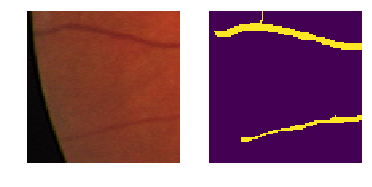

In [95]:
n = np.random.randint(0, X_train.shape[0])
plot_snippet(X_train[n], Y_train[n])

**Manipulate dataset to explore alaetoric and epistemic uncertainty**

*Alaetoric uncertainty*  
Alaetoric uncertainty is the uncertainty in the data, e.g. inherent uncertainty in the measurements, which cannot be explained away with increasing data. 
Therefore, we can expect this type of uncertainty to increase when applying gaussian noise on the image data.

*Epistemic uncertainty*  
Epististemic uncertainty is the uncertainty in the model, e.g. when trained on a limited data set.
Therefore, we can expect this type of uncertainty to increase when using only a portion of the data.

Note that we **only** manipulate the training set, and keep the test set identical such that we can directly compare the results of networks trained on the different training sets. 



-- Training set for *alaetoric* uncertainty

In [102]:
from skimage.util import random_noise
# apply gaussian noise on input image data
X_train_aleatoric = random_noise(X_train, mode='gaussian', var=0.005)
# apply salt-and-pepper noise on label data
Y_train_aleatoric = random_noise(Y_train, mode='s&p', amount=0.01)

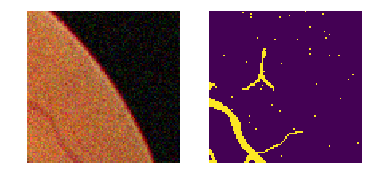

In [103]:
n = np.random.randint(0, X_train_aleatoric.shape[0])
plot_snippet(X_train_aleatoric[n], Y_train_aleatoric[n])

-- Training set for *epistemic* uncertainty

In [104]:
# use only 10% of all training data
fraction = 0.10
indices = np.random.randint(0, len(X_train_aleatoric), size=int(fraction * len(X_train_aleatoric)))
X_train_epistemic = X_train[indices]
Y_train_epistemic = Y_train[indices]

print('Number of images in training set: {}'.format(len(X_train_epistemic)))

Number of images in training set: 200


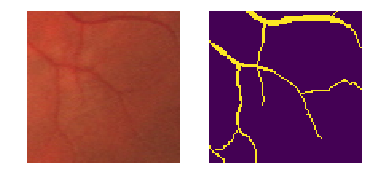

In [105]:
n = np.random.randint(0, X_train_epistemic.shape[0])
plot_snippet(X_train_epistemic[n], Y_train_epistemic[n])

# Define a convolutional neural network

In [106]:
def UNet():
    '''U net architecture (down/up sampling with skip architecture)
    '''
    from keras.layers import Input, Dropout, Activation, Add, BatchNormalization, Conv2D, Concatenate, UpSampling2D
    def Conv2DReluBatchNorm(n_filters, kernel_size, strides, inputs):
        x = Conv2D(n_filters, (1,1), strides=1, padding='same', 
                   kernel_initializer='glorot_normal',
                   activation='elu')(inputs)
        x = Conv2D(n_filters, kernel_size, strides=strides, padding='same', 
                   kernel_initializer='glorot_normal',
                   activation='elu')(x)
        x = BatchNormalization()(x)
        x = Dropout(rate=0.25)(x, training=True) # training + test-time dropout!
        return x

    inputs = Input((None, None, 3))
    
    layer1 = Conv2DReluBatchNorm(32,  (5, 5), (1,1), inputs)
    layer2 = Conv2DReluBatchNorm(64,  (5, 5), (2,2), layer1)
    layer3 = Conv2DReluBatchNorm(128, (3, 3), (2,2), layer2)
    layer4 = Conv2DReluBatchNorm(256, (3, 3), (2,2), layer3)
    layer5 = Conv2DReluBatchNorm(512, (3, 3), (2,2), layer4)

    merge6 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer5), layer4])
    layer6 = Conv2DReluBatchNorm(256, (3, 3), (1,1), merge6)
    
    merge7 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer6), layer3])
    layer7 = Conv2DReluBatchNorm(128, (3, 3), (1,1), merge7)

    merge8 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer7), layer2])
    layer8 = Conv2DReluBatchNorm(64, (3, 3), (1,1), merge8)

    merge9 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer8), layer1])
    layer9 = Conv2DReluBatchNorm(32, (3, 3), (1,1), merge9)

    output    = Conv2D(1, (1, 1), strides=(1,1), activation='sigmoid', name='output')(layer9)    

    from keras.models import Model
    return Model(inputs=inputs, outputs=output)




__Compile the network__

To compile the network, we need to choose a loss function and an optimizer. 

As a loss function, we'll use the [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).

In [107]:
from keras import backend as K
def dice_coefficient(y_true, y_pred):
    """
    A statistic used for comparing the similarity of two samples. Here binary segmentations.

    Args:
        y_true (numpy.array): the true segmentation
        y_pred (numpy.array): the predicted segmentation

    Returns:
        (float) returns a number from 0. to 1. measuring the similarity y_true and y_pred
    """
    y_true_f=K.flatten(y_true)
    mu     = y_pred[:,:,:,0]
    y_pred_f=K.flatten(mu)
    intersection=K.sum(y_true_f*y_pred_f)
    smooth=1.0
    return (2*intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coefficient(y_true, y_pred)

def recall_smooth(y_true, y_pred):
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection / (K.sum(y_true_f) + K.epsilon()))  

def precision_smooth(y_true, y_pred):
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection / (K.sum(y_pred_f) + K.epsilon()))  

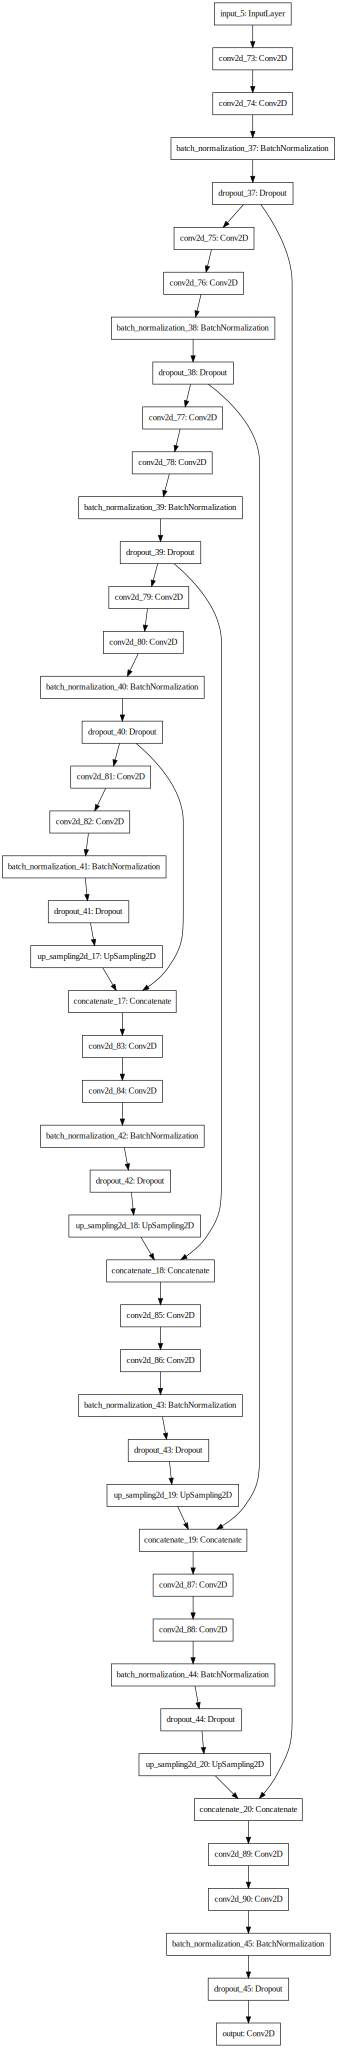

In [111]:
models = [UNet() for i in range(3)]

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(models[0], rankdir='TB').create(prog='dot', format='svg'))


In [112]:
for model in models:
    model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient, precision_smooth, recall_smooth])
    print("Number of parameters: ", model.count_params())

Number of parameters:  4452097
Number of parameters:  4452097
Number of parameters:  4452097


# Train the neural network

First, we train a model on the normal full dataset.  
Next, we train two models on manipulated datasets (one noisy and one small data set).


In [114]:
batch_size = 48
epochs = 40

In [115]:
histories = []
for i, model in enumerate(models):
    
    if i == 0:
        X_data = X_train
        Y_data = Y_train
    if i == 1:
        X_data = X_train_aleatoric
        Y_data = Y_train_aleatoric
    if i == 2:
        X_data = X_train_epistemic
        Y_data = Y_train_epistemic
    
    history = model.fit(X_data, Y_data,
                          batch_size=batch_size,
                          epochs=epochs,
                          shuffle=True,
                          verbose=1,
                          validation_data=(X_test, Y_test))
    histories.append(history)


Train on 2000 samples, validate on 200 samples
Epoch 1/40
2000/2000 [==============================] - 11s 5ms/step - loss: 0.5888 - dice_coefficient: 0.4112 - precision_smooth: 0.2785 - recall_smooth: 0.8281 - val_loss: 0.7401 - val_dice_coefficient: 0.2599 - val_precision_smooth: 0.2641 - val_recall_smooth: 0.2564
Epoch 2/40
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3937 - dice_coefficient: 0.6063 - precision_smooth: 0.4800 - recall_smooth: 0.8326 - val_loss: 0.5022 - val_dice_coefficient: 0.4978 - val_precision_smooth: 0.5317 - val_recall_smooth: 0.4684
Epoch 3/40
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3036 - dice_coefficient: 0.6964 - precision_smooth: 0.6124 - recall_smooth: 0.8115 - val_loss: 0.2807 - val_dice_coefficient: 0.7193 - val_precision_smooth: 0.6455 - val_recall_smooth: 0.8130
Epoch 4/40
2000/2000 [==============================] - 6s 3ms/step - loss: 0.2567 - dice_coefficient: 0.7433 - precision_smooth: 0.6947 - rec

In [131]:
def plot_history(history, title=None, bottom_zero=False, top_one=False):
    '''Plot history from keras history object
    
    Args:
    - keras History object: https://keras.io/callbacks/#history
    - title (str): if provided, puts title above plot
    
    Returns:
    - matplotlib figure
    '''
    
    # get names of losses and metrics
    keys = history.history.keys()
    # check whether there is validation
    has_val = any([key.startswith('val_') for key in keys])
    if has_val:
        # filter out the 'val_' 
        keys_noval = [key for key in keys if not key.startswith('val_') ]
        # filter out items without 'val_'
        keys_val = [key for key in keys if key.startswith('val_') ]

    # create figure with subplots
    fig, axes = plt.subplots(1, len(keys_noval), figsize=(len(keys_noval)*5,5))

    # plot losses and metrics
    for i, (key, ax) in enumerate(zip(keys_noval, axes.flatten())):
        ax.plot(history.history[key], label=key)
        # if there is validation data, plot this too
        if has_val:
            valkey = keys_val[i] # corresponding key with val_
            ax.plot(history.history[valkey], label=valkey)
        ax.legend() 
        ax.set_title(key.capitalize())
        ax.set_xlabel('Epochs')
        if bottom_zero:
            ax.set_ylim(bottom=0.)
        if top_one:
            ax.set_ylim(top=1.)

    # set title above plot, if provided
    if title is not None:
        fig.suptitle(title, fontsize=16)
    
    return fig


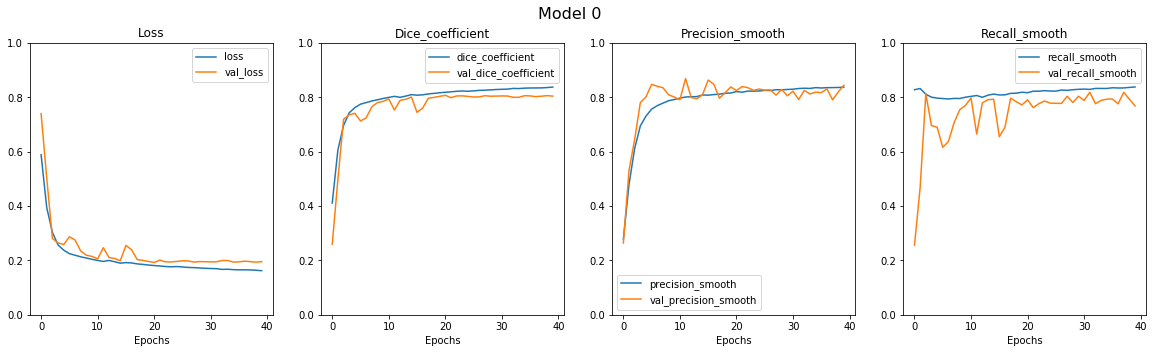

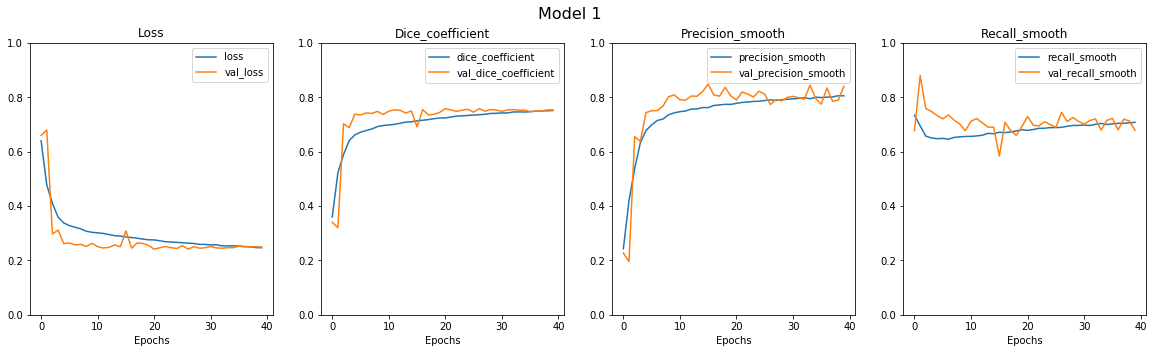

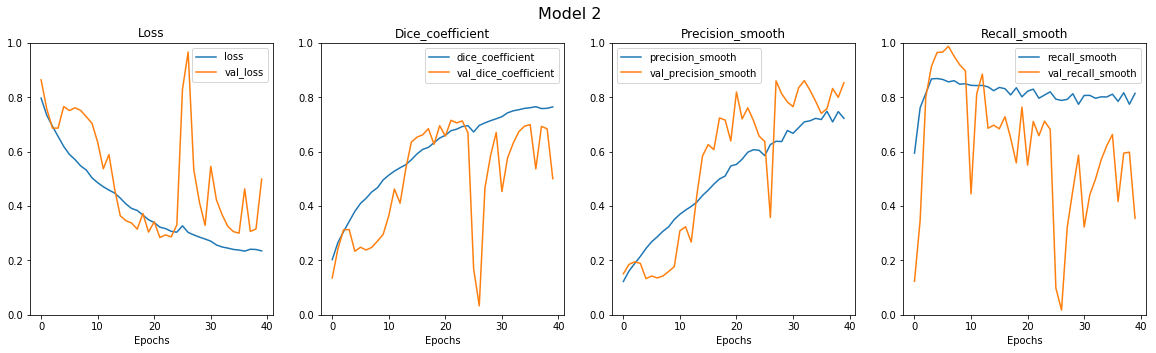

In [132]:
for i, history in enumerate(histories):
    _ = plot_history(history, title="Model {}".format(i), bottom_zero=True, top_one=True)

In [117]:
for i, model in enumerate(models):
    print('\n === Model {} ===\n'.format(i))
    
    scores = model.evaluate(X_test, Y_test, verbose=1)
    for score, metric_name in zip(scores, model.metrics_names):
        print('{: <20s} = {:.3f}'.format(metric_name, score))
    


 === Model 0 ===

200/200 [==============================] - 0s 1ms/step
loss                 = 0.197
dice_coefficient     = 0.803
precision_smooth     = 0.842
recall_smooth        = 0.768

 === Model 1 ===

200/200 [==============================] - 0s 1ms/step
loss                 = 0.250
dice_coefficient     = 0.750
precision_smooth     = 0.841
recall_smooth        = 0.678

 === Model 2 ===

200/200 [==============================] - 0s 1ms/step
loss                 = 0.502
dice_coefficient     = 0.498
precision_smooth     = 0.857
recall_smooth        = 0.352


# Predict with uncertainties

In [118]:
def predict(model, image, gt, T=10):
    
    # add batch dimension
    image = np.expand_dims(image, 0)
    gt = np.expand_dims(gt, 0)
    
    # predict stochastic dropout model T times
    p_hat = []
    for t in range(T):
        p_hat.append( model.predict(image)[0] )
    p_hat = np.array(p_hat)
    
    # mean prediction
    prediction = np.mean(p_hat, axis=0)
    # threshold mean prediction
    #prediction = np.where(prediction > 0.5, 1, 0)
    
    #####################################################################################
    ################# ESTIMATION OF UNCERTAINTIES #######################################
    # according to Kwon et al. (2018)
    # see equation 4 in https://openreview.net/pdf?id=Sk_P2Q9sG
    # see https://github.com/ykwon0407/UQ_BNN/issues/1
    aleatoric = np.mean(p_hat*(1-p_hat), axis=0)
    epistemic = np.mean(p_hat**2, axis=0) - np.mean(p_hat, axis=0)**2
    #####################################################################################
    
    loss, dice, precision, recall = model.evaluate(image, gt, batch_size=1)

    return np.squeeze(prediction), np.squeeze(aleatoric), np.squeeze(epistemic), (dice, precision, recall)

In [154]:
def plot_predictions(gt, prediction, aleatoric, epistemic, scores, title="", filename=None):
    
    fig, ax = plt.subplots(2,3,figsize=(12,6))
    
    dice, recall, precision = scores
    fig.suptitle('{}\nDice: {:.2f}, Recall: {:.2f}, Precision: {:.2f}\n'.format(title, dice, recall, precision), y=1.0, fontsize=14)
    
    cax0 = ax[0,0].imshow(image)
    plt.colorbar(cax0, ax=ax[0,0])
    ax[0,0].set_title('image')

    cax1 = ax[0,1].imshow(prediction)
    plt.colorbar(cax1, ax=ax[0,1])
    ax[0,1].set_title('prediction')

    cax2 = ax[0,2].imshow(gt)
    plt.colorbar(cax2, ax=ax[0,2])
    ax[0,2].set_title('annotation')
    
    cax3 = ax[1,0].imshow(aleatoric)
    plt.colorbar(cax3, ax=ax[1,0])
    ax[1,0].set_title('aleatoric')
    
    cax4 = ax[1,1].imshow(epistemic)
    plt.colorbar(cax4, ax=ax[1,1])
    ax[1,1].set_title('epistemic')

    cax5 = ax[1,2].imshow(aleatoric+epistemic)
    plt.colorbar(cax4, ax=ax[1,2])
    ax[1,2].set_title('uncertainty (sum)')

    for a in ax.flatten(): a.axis('off')
        
    if filename is not None:
        fig.savefig(filename, dpi=300)
    
    plt.show()
    plt.close()

# Predict unseen examples

In [155]:
# generate images to test
X_predict, Y_predict = get_random_snippets(x_test, y_test, number=200, size=(128,128), noisy=False)

1/1 [==============================] - 0s 6ms/step


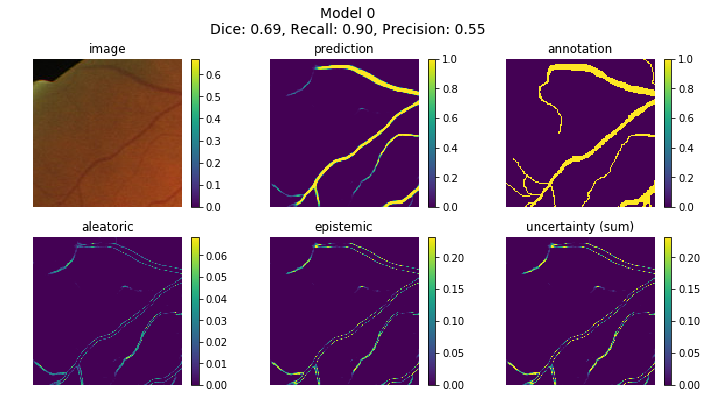

1/1 [==============================] - 0s 6ms/step


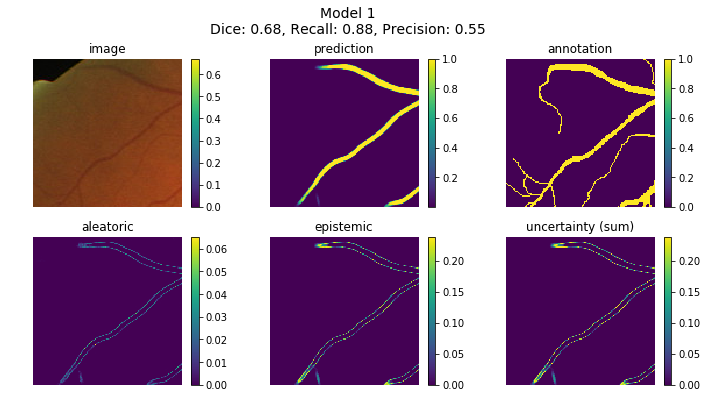

1/1 [==============================] - 0s 7ms/step


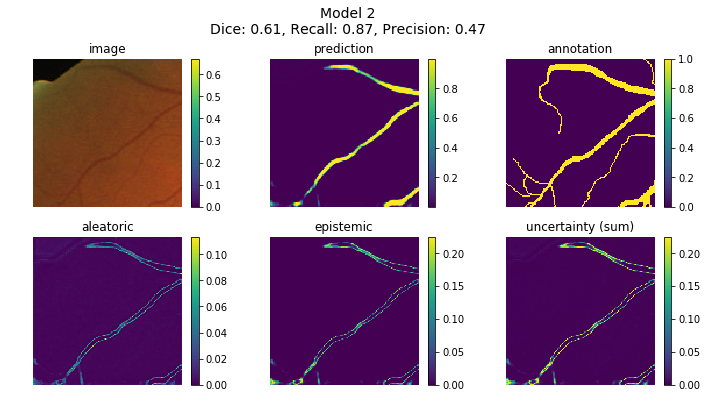

1/1 [==============================] - 0s 6ms/step


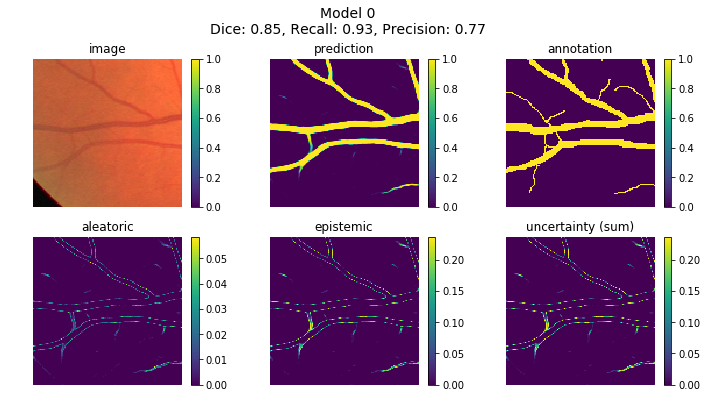

1/1 [==============================] - 0s 5ms/step


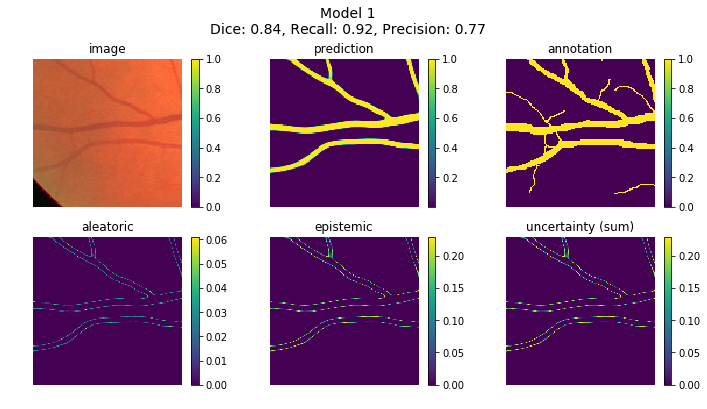

1/1 [==============================] - 0s 5ms/step


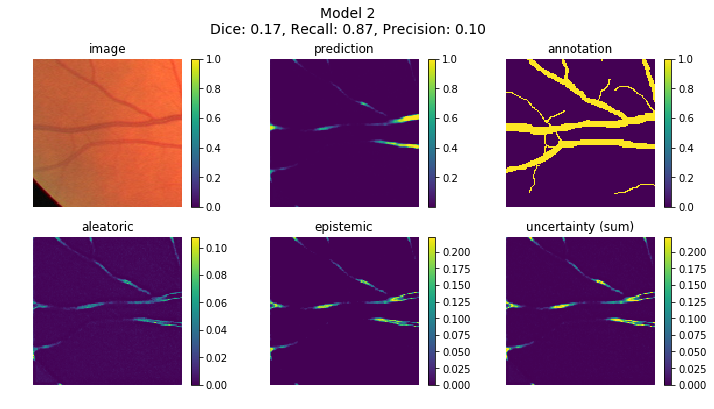

1/1 [==============================] - 0s 6ms/step


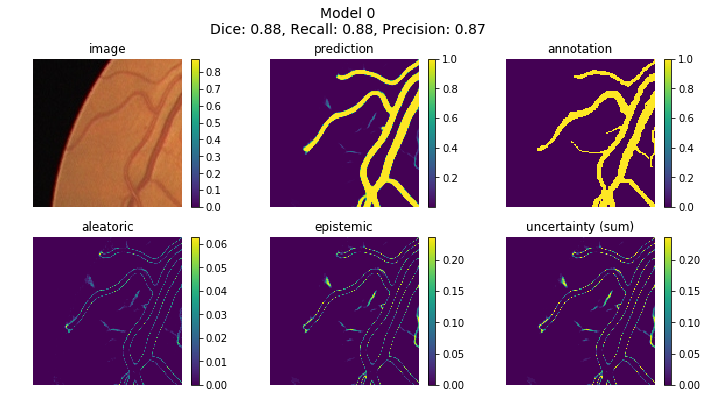

1/1 [==============================] - 0s 6ms/step


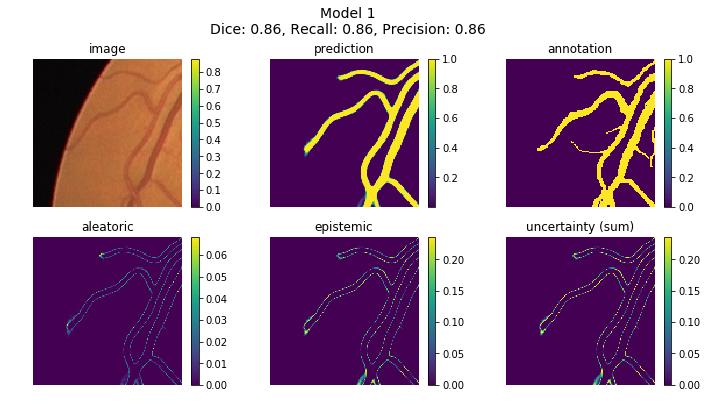

1/1 [==============================] - 0s 6ms/step


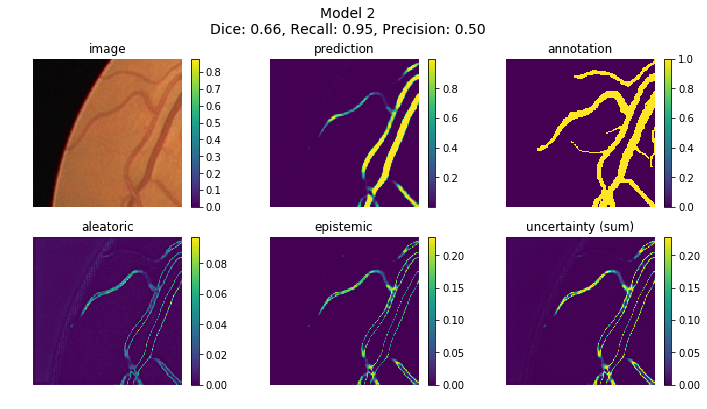

1/1 [==============================] - 0s 6ms/step


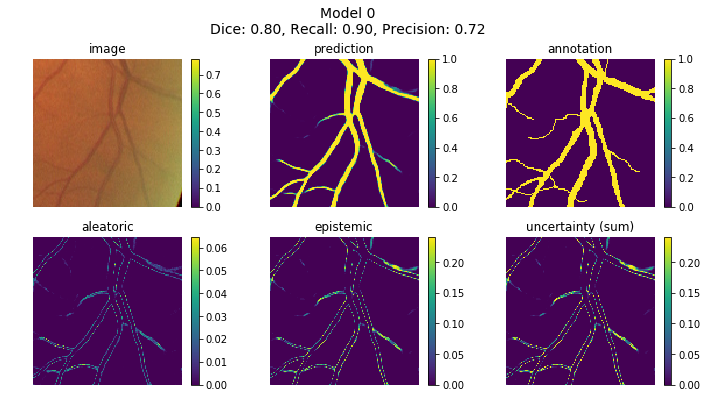

1/1 [==============================] - 0s 6ms/step


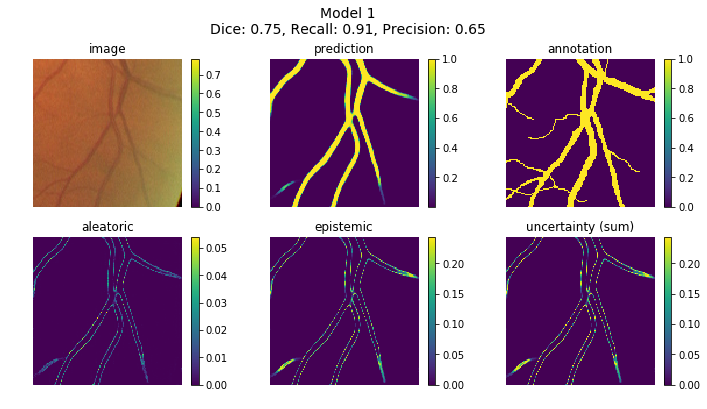

1/1 [==============================] - 0s 5ms/step


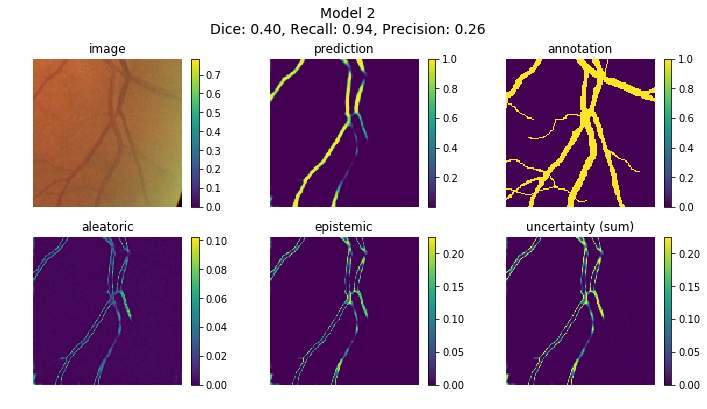

1/1 [==============================] - 0s 6ms/step


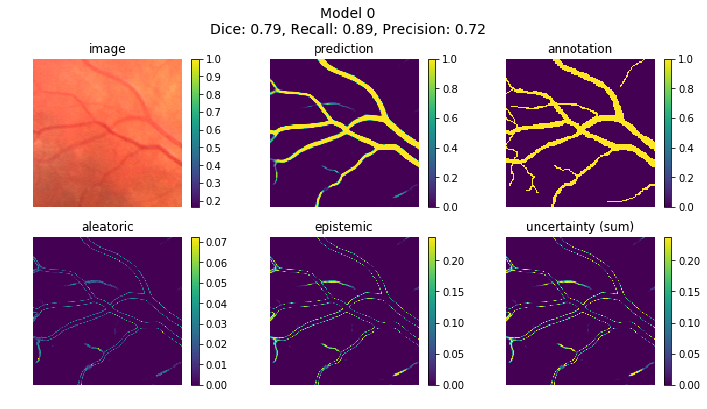

1/1 [==============================] - 0s 6ms/step


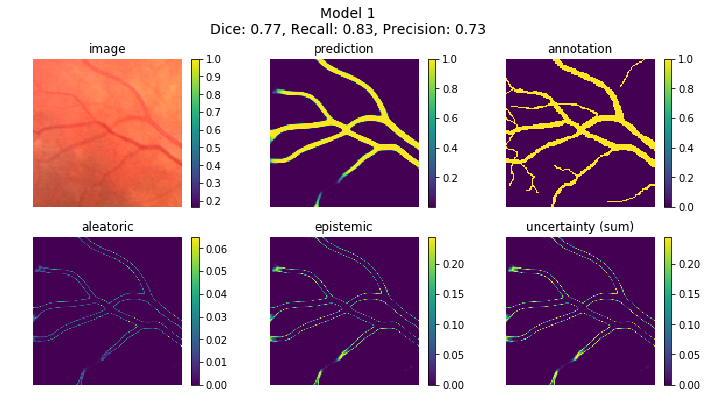

1/1 [==============================] - 0s 6ms/step


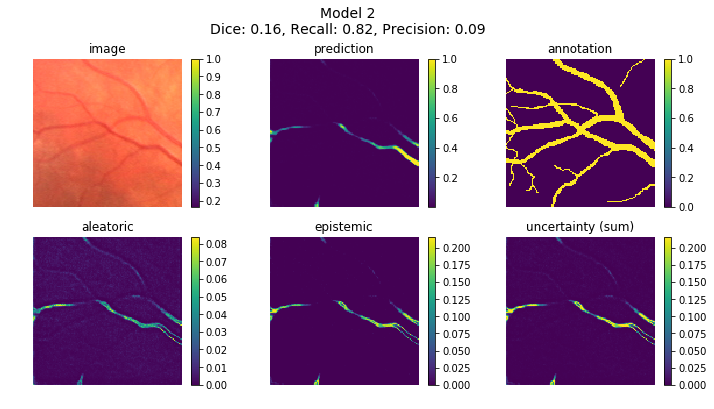

1/1 [==============================] - 0s 6ms/step


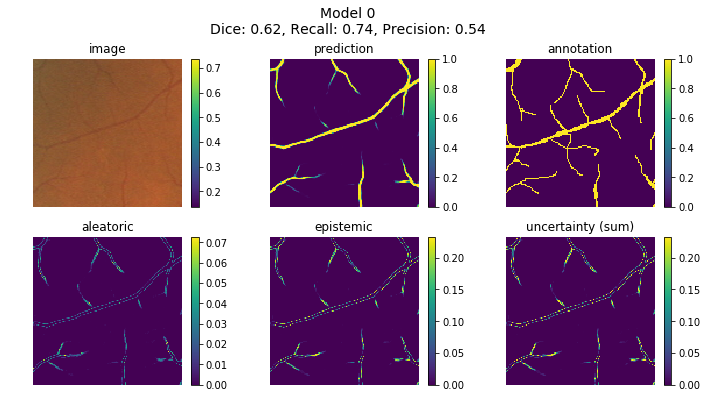

1/1 [==============================] - 0s 6ms/step


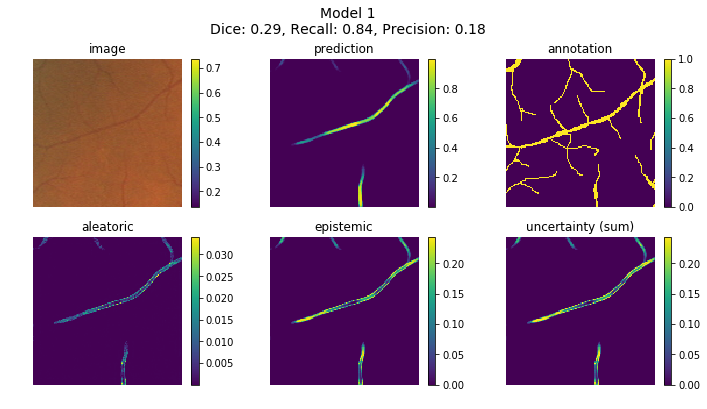

1/1 [==============================] - 0s 6ms/step


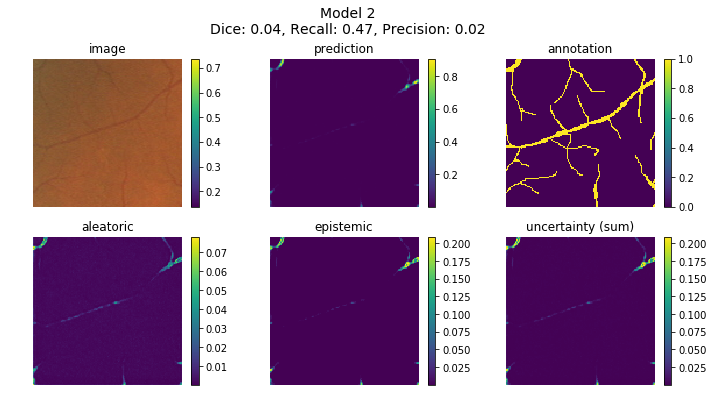

1/1 [==============================] - 0s 6ms/step


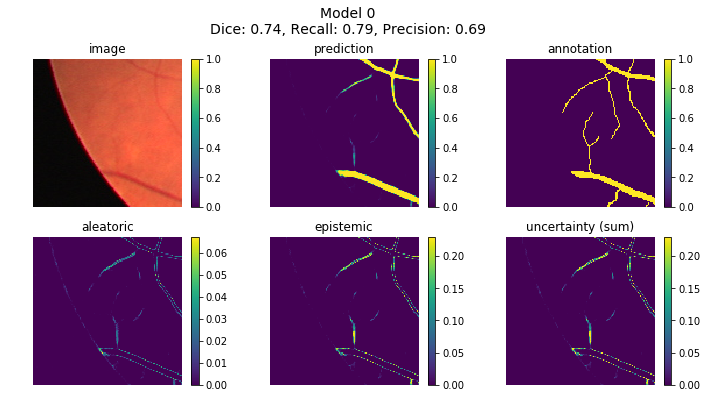

1/1 [==============================] - 0s 6ms/step


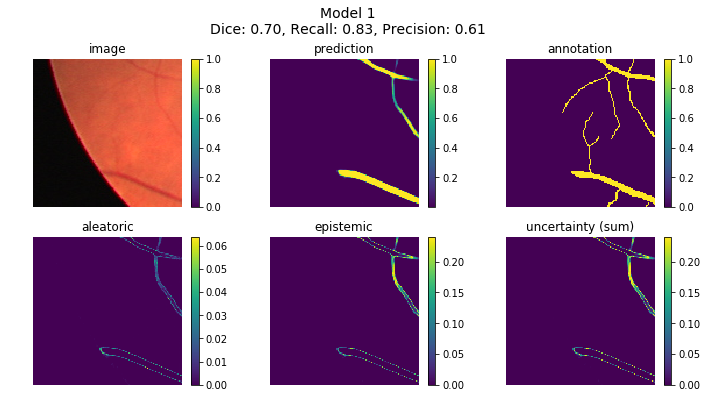

1/1 [==============================] - 0s 6ms/step


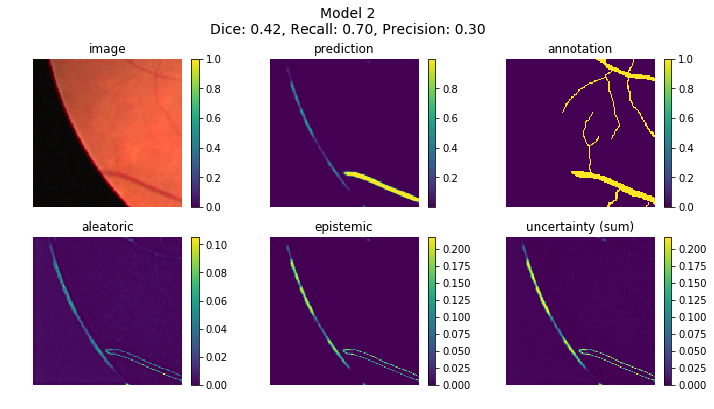

1/1 [==============================] - 0s 6ms/step


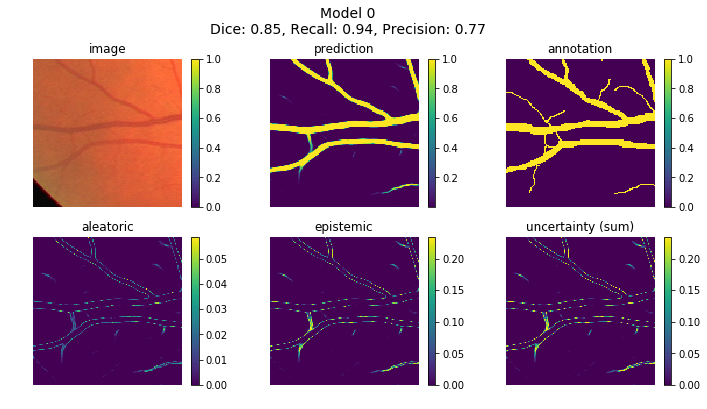

1/1 [==============================] - 0s 5ms/step


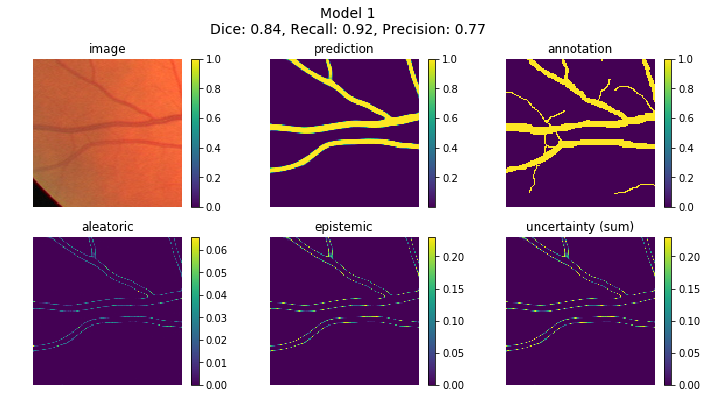

1/1 [==============================] - 0s 6ms/step


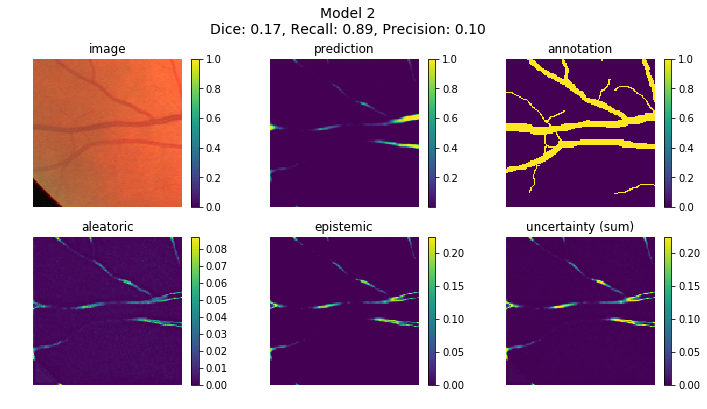

1/1 [==============================] - 0s 6ms/step


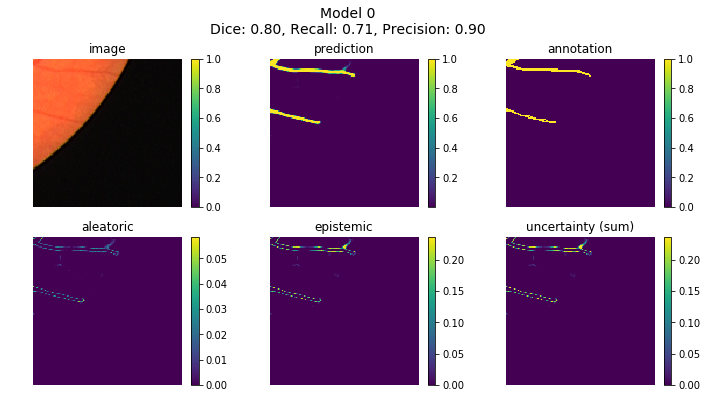

1/1 [==============================] - 0s 6ms/step


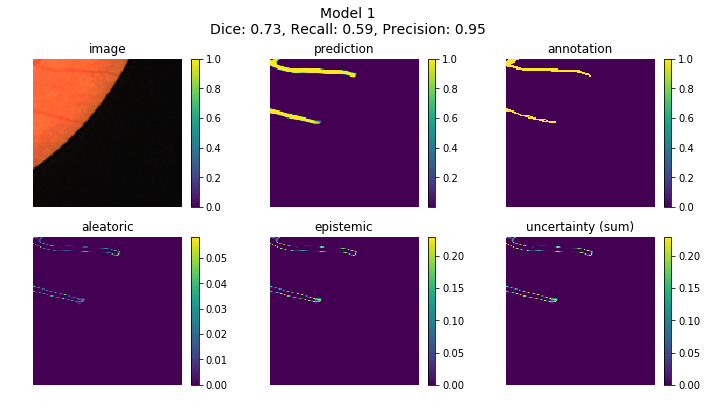

1/1 [==============================] - 0s 6ms/step


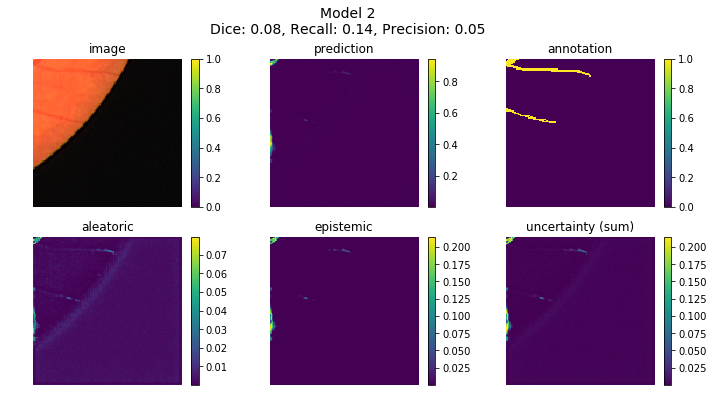

1/1 [==============================] - 0s 6ms/step


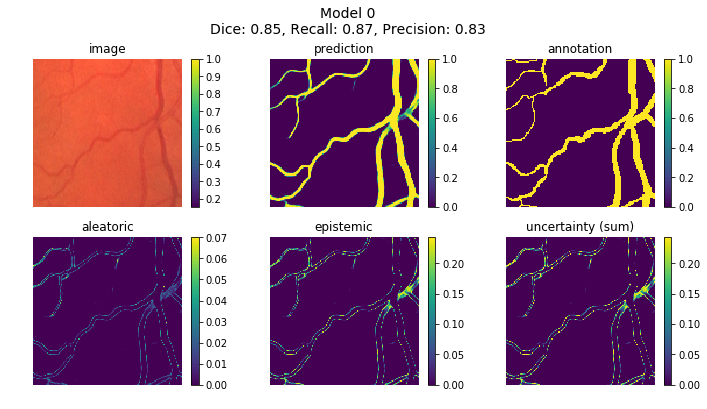

1/1 [==============================] - 0s 6ms/step


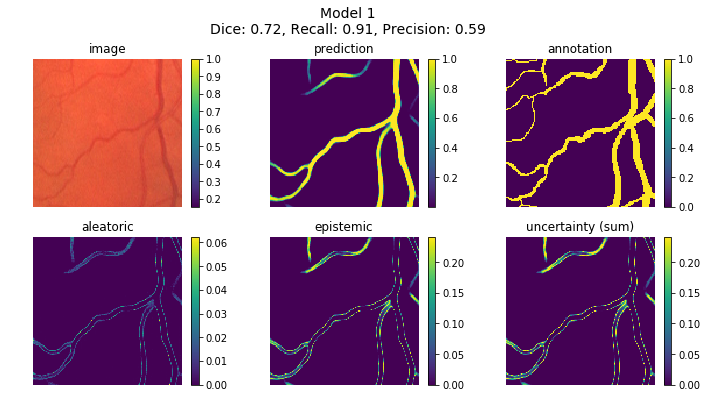

1/1 [==============================] - 0s 6ms/step


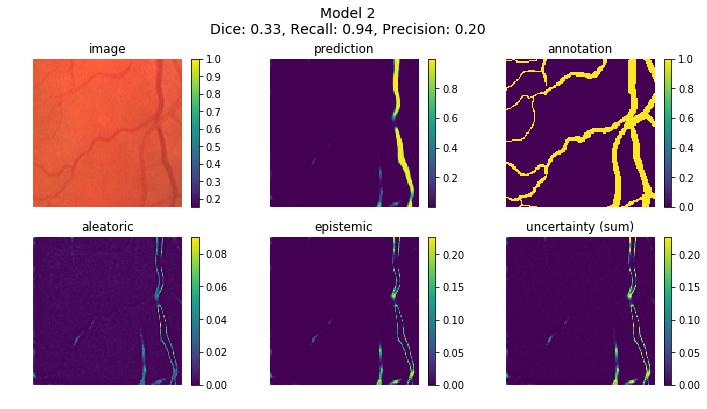

Exec time per prediction = 5.605


In [157]:
num = 10
import time
start = time.time()

for i in range(num):
    sample = np.random.randint(0,len(X_predict))
    image = X_predict[sample]
    gt    = Y_predict[sample]
    
    for m, model in enumerate(models):
        results = predict(model, image, gt, T=100)
        plot_predictions(np.squeeze(gt), *results, title='Model {}'.format(m), filename='../output/prediction_uncertainty_image{:03d}_model{:03d}.png'.format(i, m))

    print(' ======================================= ')

end = time.time()
print('Exec time per prediction = {:.3f}'.format((end-start)/num))